<a href="https://colab.research.google.com/github/nmurillon/DeepLearningChallenge/blob/main/Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge Deep Learning

Travail de Dorian Gravegeal et Nicolas Murillon



###Imports


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Ajouter les imports nécessaires
import os
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

###Variables globales

In [2]:
num_epochs = 100
batch_size = 250

img_shape = (28,28,1)
img_size = img_shape[:2]

num_classes = 5
stop_freeze = 4


#Premier modèle
Dans un premier temps, nous avons cherché à faire un réseau CNN assez simple en s'inspirant de celui que nous avons vu en cours.
Pour cela il faut d'abord définir les fonctions permettant de charger les données d'entraînement et de validation.

##Données

Nous allons donc commencer par monter notre drive afin de récupérer le fichier zip contenant les images. Le drive nous permettra également de stocker nos résultats

In [3]:
#On monte le drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Copie du zip dans le stockage local de la vm
!cp -r /content/drive/MyDrive/DeepLearning/ /content/sample_data/

In [5]:
#unzip
!unzip -qq /content/sample_data/DeepLearning/Data_Train_Valid.zip -d /content/sample_data/DeepLearning

In [6]:
#on change le répertoire courant pour faciliter l'accès aux données
os.chdir('/content/sample_data/DeepLearning') 

On définit ensuite les classes dont nous avons avoir besoin, puis on lit les données grâce au module panda. Lors de la lecture des données, on précise que le type de données lu doit être convertit en chaîne de caractères afin de pouvoir utiliser un générateur (voir par la suite)

In [7]:
classes = ["basket","eye","binoculars","rabbit","hand"]

train = pd.read_csv('train.csv', dtype="str")
valid = pd.read_csv('valid.csv', dtype="str")

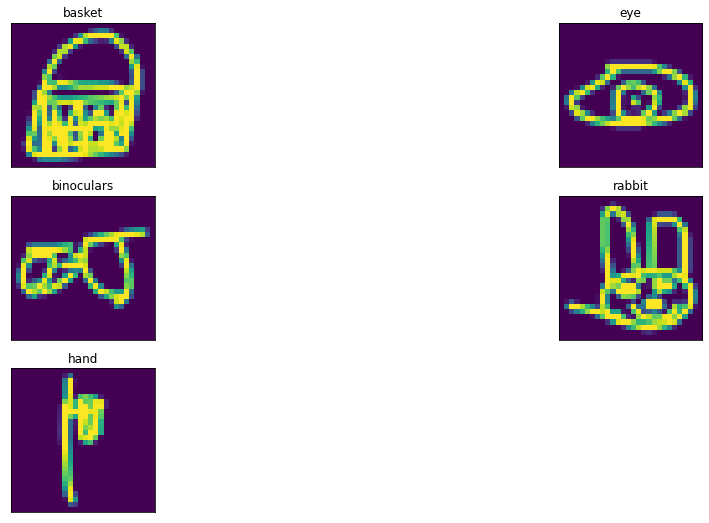

In [8]:
plt.figure(figsize=(18,9))
for i in range(0,5):
    ax= plt.subplot(3,2 ,i+1)
    mydata = pd.read_csv("train.csv",skiprows = [1], nrows=1)
    im = Image.open('images/'+classes[i]+'/'+ os.listdir("images/"+classes[i])[0])
    fig=ax.imshow(im)
    plt.title(classes[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()    


On utilise également un ImageDataGenerator puisque ce dernier permet de charger les données grâce à un dataframe (obtenu grâce au module panda)

In [9]:
#Utilisation d'un générateur pour pouvoir utiliser le dataframe fourni par panda
ImageGenerator = ImageDataGenerator(
    rescale = 1./255, 
)

train_generator = ImageGenerator.flow_from_dataframe(
    dataframe=train, # Données provenant de pandas pour l'entrainement
    directory="images", # Dossier racine des images
    x_col="relative_path", # Chemin d'acces des images
    y_col="class_label", # Nom des classes 
    class_mode="categorical", # Type de classification : 
    target_size=(28,28),
    color_mode="grayscale",
    batch_size=batch_size,
    validate_filenames=False, # Pas de vérification des fichiers pour gagner du temps
    shuffle=True, # En rendant aléatoire les données on augmente les chances d'avoir un lancement meilleur
    horizontal_flip=True
)

valid_generator = ImageGenerator.flow_from_dataframe(
    dataframe=valid, # Données provenant de pandas pour l'entrainement
    directory="images", # Dossier racine des images
    x_col="relative_path", # Chemin d'acces des images
    y_col="class_label", # Nom des classes 
    class_mode="categorical", # Type de classification : 
    target_size=(28,28),
    color_mode="grayscale",
    batch_size=batch_size,
    validate_filenames=False, # Pas de vérification des fichiers pour gagner du temps
    shuffle=True, # En rendant aléatoire les données on augmente les chances d'avoir un lancement meilleur
)

Found 75000 non-validated image filenames belonging to 5 classes.
Found 25000 non-validated image filenames belonging to 5 classes.


##Entraînement du réseau

On commence par définir la structure de notre réseau.

In [10]:
def getModel(dropout=0.2, Conv2DActivation='relu', DenseActivation='relu', optimizer='adam', loss='categorical_crossentropy'):
    model = Sequential([
    Conv2D(32,  input_shape=img_shape, kernel_size=(3,3), activation=Conv2DActivation, name="Conv1"),
    Conv2D(32, kernel_size=(3,3), activation=Conv2DActivation, name="Conv1b"),
    MaxPooling2D(name="MaxPool1"),    
    Conv2D(64, kernel_size=(3,3), activation=Conv2DActivation, name="Conv2"),
    Conv2D(64, kernel_size=(3,3), activation=Conv2DActivation, name="Conv2b"),
    MaxPooling2D(name="MaxPool2"),
    Flatten(name="Flatten"),
    Dropout(dropout, name="Dropout1"),
    Dense(1024, activation=DenseActivation, name="Dense1"),
    Dense(50, activation=DenseActivation, name="Dense2"),
    Dropout(dropout, name="Dropout2"),
    Dense(5, activation="softmax", name="Classif")                  
    ])
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

    return model

In [11]:
#Construction du modèle

model = getModel(dropout=0.5)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 Conv1b (Conv2D)             (None, 24, 24, 32)        9248      
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 12, 12, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 10, 10, 64)        18496     
                                                                 
 Conv2b (Conv2D)             (None, 8, 8, 64)          36928     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 4, 4, 64)          0         
                                                                 
 Flatten (Flatten)           (None, 1024)              0

On définit ensuite les callbacks que nous allons utiliser pour l'entraînement.
Le premier permet de sauvegarder le réseau chaque fois que le résultat obtenu est meilleur que le précédent. Nous avons également utilisé un deuxième callbacks permettant d'arrêter l'entraînement après un 10 epochs si la valeur de **val_loss** n'a pas diminué par rapport à la meilleur valeure obtenue auparavant.

On entraîne ensuite le modèle.

In [12]:
# # Callback pour la sauvegarde du meilleur modèle
if not os.path.isdir("/content/sample_data/DeepLearning/sauve"):
    os.mkdir("/content/sample_data/DeepLearning/sauve")
    
checkpoint = ModelCheckpoint("/content/sample_data/DeepLearning/sauve/CNN-epoch-{epoch:03d}-loss-{val_loss:.2f}-acc-{accuracy:.2f}-val_acc-{val_accuracy:.3f}.h5",
                                save_best_only=True,verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', mode="min", patience=10)
#Entrainement Data_generator

val_steps_epoch = np.ceil(valid_generator.samples / batch_size)

history = model.fit(train_generator, 
                    validation_data=valid_generator,
                    validation_steps=val_steps_epoch, 
                    epochs=num_epochs, 
                    verbose=1, 
                    callbacks=[checkpoint, early_stopping])

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.5197 - accuracy: 0.8261
Epoch 00001: val_loss improved from inf to 0.23790, saving model to /content/sample_data/DeepLearning/sauve/CNN-epoch-001-loss-0.24-acc-0.83-val_acc-0.920.h5
300/300 [==============================] - 46s 110ms/step - loss: 0.5197 - accuracy: 0.8261 - val_loss: 0.2379 - val_accuracy: 0.9203
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.9137
Epoch 00002: val_loss improved from 0.23790 to 0.18412, saving model to /content/sample_data/DeepLearning/sauve/CNN-epoch-002-loss-0.18-acc-0.91-val_acc-0.938.h5
300/300 [==============================] - 31s 105ms/step - loss: 0.2736 - accuracy: 0.9137 - val_loss: 0.1841 - val_accuracy: 0.9384
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9307
Epoch 00003: val_loss improved from 0.18412 to 0.15677, saving model to /content/sample_data/DeepLearning/sauve/CNN-epoch

On affiche ensuite le résultat de l'apprentissage sous forme de graphe.

Dans notre cas, aucun sur-entraînement n'est apparu. Le modèle présenté ici est celui pour lequel nous avons obtenu les meilleurs résultats.

Nous avons essayé de faire varier les paramètres du réseaux tels que :
  - Dropout
  - Fonction d'Activation
  - Optimpizer

Sur tous les modèles que nous avons pu tester, la précision variait de 90% pour le pire des modèles à 95,9% pour le meilleur.

Au vu des résultats, nous avons gardé la configuration suivante:
  - Dropout : 0.5
  - Fonction d'Activation : Relu
  - Optimpizer : Adam

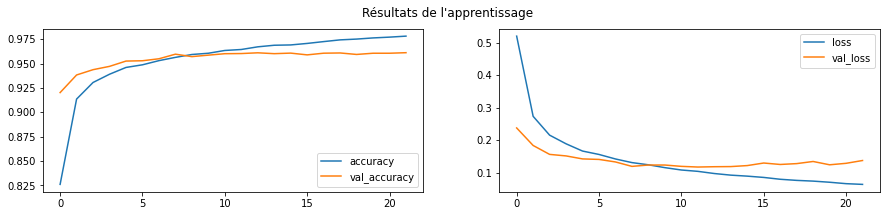

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
fig.suptitle("Résultats de l'apprentissage")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.legend(['accuracy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.legend(['loss', 'val_loss'])
plt.savefig("training.png",dpi=100)

In [14]:
!cp -R /content/sample_data/DeepLearning/sauve /content/drive/MyDrive/DeepLearning/

Pour finir, nous avons évalué notre réseau. Ce dernier nous permet d'obtenir une précision de 95,85%

In [15]:
#Construction du meilleur modèle
model = getModel(0.5)
model.load_weights("/content/sample_data/DeepLearning/sauve/CNN-epoch-008-loss-0.12-acc-0.96-val_acc-0.960.h5")

# Evaluation du modèle
evaluation = model.evaluate(valid_generator, verbose=1)
print("Perte = {0:5.3f}, Précision = {1:5.3f}".format(evaluation[0], evaluation[1]))

100/100 [==============================] - 8s 73ms/step - loss: 0.1200 - accuracy: 0.9598
Perte = 0.120, Précision = 0.960


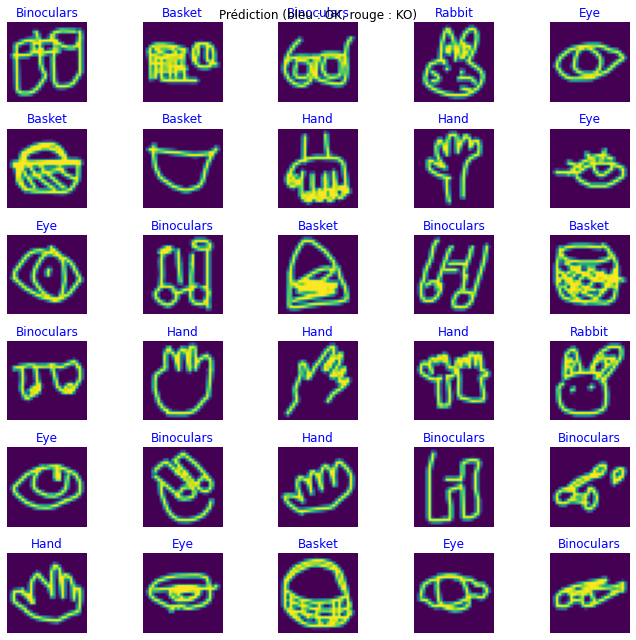

In [16]:
# Quelques exemples de bonne / mauvaise classification

#With Data_generator
image_batch, label_batch = next(iter(valid_generator))
label_batch = [classes[np.argmax(label_batch[i])] for i in range(batch_size)]
predicted_classes = model.predict(image_batch)

predicted_ids = [np.argmax(predicted_classes[i]) for i in range(batch_size)]
predicted_classes = np.array([classes[id] for id in predicted_ids])

plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n].reshape(28,28))
    if predicted_classes[n] == label_batch[n]:
        color = "blue"
        title = predicted_classes[n].title()
    else:
        color = "red"
        title = f"{predicted_classes[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Prédiction (bleu : OK, rouge : KO)")
plt.tight_layout()
plt.savefig("res.png",dpi=100)


#Deuxième modèle

Dans un second temps, nous avons essayé de faire du transfer Learning.

Nous avons alors essayé de charger des modèles existants tels que MobileNetV2.

Plusieurs problèmes se sont présentés à nous. En effet, les réseaux pré-entraînés n'acceptent pas d'images dont la taille est inférieure à 32x32 pixels. De plus, les images doivent être en RGB.

Ces contraintes nous obligent à utiliser un générateur afin de ne pas saturer la RAM.

Nous avons donc essayé d'utiliser le réseau MobileNetV2. Un autre problème est alors apparu, pour des images RGB de 224x224 pixels, les temps d'entraînement sont beaucoup plus longs que pour le réseau que nous avons présenté en première partie. En effet, pour ce dernier, le temps d'entraînement complet est de 45min à 1h, tandis que pour le modèle pré-entrainé, il faut environ 3min par epoch.

Par ailleurs, au vu des tests que nous avons fait, nous arrivons rapidement dans des situations de sur-entraînement pour un résultat moins bon que le premier modèle (environ 93% de réussite)

Nous avons donc abandonné cette piste

#Troisième modèle

Dans un troisième temps, nous nous sommes penchés sur l'augmentation des données. Le jeu de données fourni est assez conséquent mais nous avons essayé d'entraîner notre réseau sur un jeu de données encore plus grand.

Pour cela, nous avons récupéré l'ensemble des 5 catégories d'images sur quickdraw. Cela représente environ 160000 images pour chaque catégorie.

Le réseau choisi est le même que celui présenté dans la première partie et grâce à l'entraînement, nous obtenons une précision dépassant les 97%.

### Import en local des jeux de données récupérés sur Quickdraw
Nous avons joint àce document les 5 fichiers contenant le jeu d'images complet par catégorie. (fichiers full_numpy_bitmap_binoculars.npy, full_numpy_bitmap_basket.npy, full_numpy_bitmap_eye.npy, full_numpy_bitmap_rabbit.npy, full_numpy_bitmap_hand.npy)

In [4]:
!cp /content/drive/MyDrive/DeepLearning/Imports/full_numpy_bitmap_binoculars.npy /content/sample_data
!cp /content/drive/MyDrive/DeepLearning/Imports/full_numpy_bitmap_basket.npy /content/sample_data
!cp /content/drive/MyDrive/DeepLearning/Imports/full_numpy_bitmap_eye.npy /content/sample_data
!cp /content/drive/MyDrive/DeepLearning/Imports/full_numpy_bitmap_rabbit.npy /content/sample_data
!cp /content/drive/MyDrive/DeepLearning/Imports/full_numpy_bitmap_hand.npy /content/sample_data

### Chargement des données
Afin d'être certain que les images de validation ne soient pas comprises dans le jeu d'entrainement, nous n'avons pas utilisé le jeu de validation que vous proposez. Nous avons découpé directement le jeu de données que nous avons récupéré en un sous-ensemble d'entrainement et un sous-ensemble de validation.

In [23]:
validation_size = 40000

classesIndex = ["basket","eye","binoculars","rabbit","hand"]
# Pour le chargement des données
classes = {
    'basket': {
        'class_label': [1,0,0,0,0],
        'length': 0,
        'images': None,
        'labels': None
    },
    'eye': {
        'class_label': [0,1,0,0,0],
        'length': 0,
        'images': None,
        'labels': None
    },
    'binoculars': {
        'class_label': [0,0,1,0,0],
        'length': 0,
        'images': None,
        'labels': None
    },
    'rabbit': {
        'class_label': [0,0,0,1,0],
        'length': 0,
        'images': None,
        'labels': None
    },
    'hand': {
        'class_label': [0,0,0,0,1],
        'length': 0,
        'images': None,
        'labels': None
    },
} 

for category in classes:
  cat = np.load(f'/content/sample_data/full_numpy_bitmap_{category}.npy')
  length = len(cat)
  cat = cat.reshape((length,28,28,1))
  labels = np.full((length,5), classes[category]['class_label'])

  classes[category]["images"] = cat
  classes[category]["labels"] = labels
  classes[category]["length"] = length
  print(f'length of {category} : {length}')

#Simplifier la notation
baskets = classes["basket"]["images"]
eyes = classes["eye"]["images"]
binoculars = classes["binoculars"]["images"]
rabbits = classes["rabbit"]["images"]
hands = classes["hand"]["images"]

# Découpage du jeu de données
train_images = np.concatenate((baskets[:(len(baskets) - validation_size)],
                              eyes[:(len(eyes) - validation_size)],
                              binoculars[:(len(binoculars) - validation_size)],
                              rabbits[:(len(rabbits) - validation_size)],
                              hands[:(len(hands) - validation_size)])
                              , axis=0)
validation_images = np.concatenate((baskets[-validation_size:],
                                    eyes[-validation_size:],
                                    binoculars[-validation_size:],
                                    rabbits[-validation_size:],
                                    hands[-validation_size:]),
                                    axis=0)

basketslabels = classes["basket"]["labels"]
eyeslabels = classes["eye"]["labels"]
binocularslabels = classes["binoculars"]["labels"]
rabbitslabels = classes["rabbit"]["labels"]
handslabels = classes["hand"]["labels"]

train_labels = np.concatenate((basketslabels[:(len(basketslabels) - validation_size)],
                               eyeslabels[:(len(eyeslabels) - validation_size)],
                               binocularslabels[:(len(binocularslabels) - validation_size)],
                               rabbitslabels[:(len(rabbitslabels) - validation_size)],
                               handslabels[:(len(handslabels) - validation_size)]),
                               axis=0)
validation_labels = np.concatenate((basketslabels[-validation_size:],
                                    eyeslabels[-validation_size:],
                                    binocularslabels[-validation_size:]
                                    , rabbitslabels[-validation_size:],
                                    handslabels[-validation_size:]),
                                    axis=0)

#On mélange les catégories
randomize = np.arange(len(train_images))
np.random.shuffle(randomize)
x_train = train_images[randomize]
y_train = train_labels[randomize]

randomize = np.arange(len(validation_images))
np.random.shuffle(randomize)
x_test = validation_images[randomize]
y_test = validation_labels[randomize]

length of basket : 118458
length of eye : 125888
length of binoculars : 124190
length of rabbit : 155288
length of hand : 291773


In [24]:
print(len(x_train))
print(len(x_test))

615597
200000


### Affichage du des images chargées

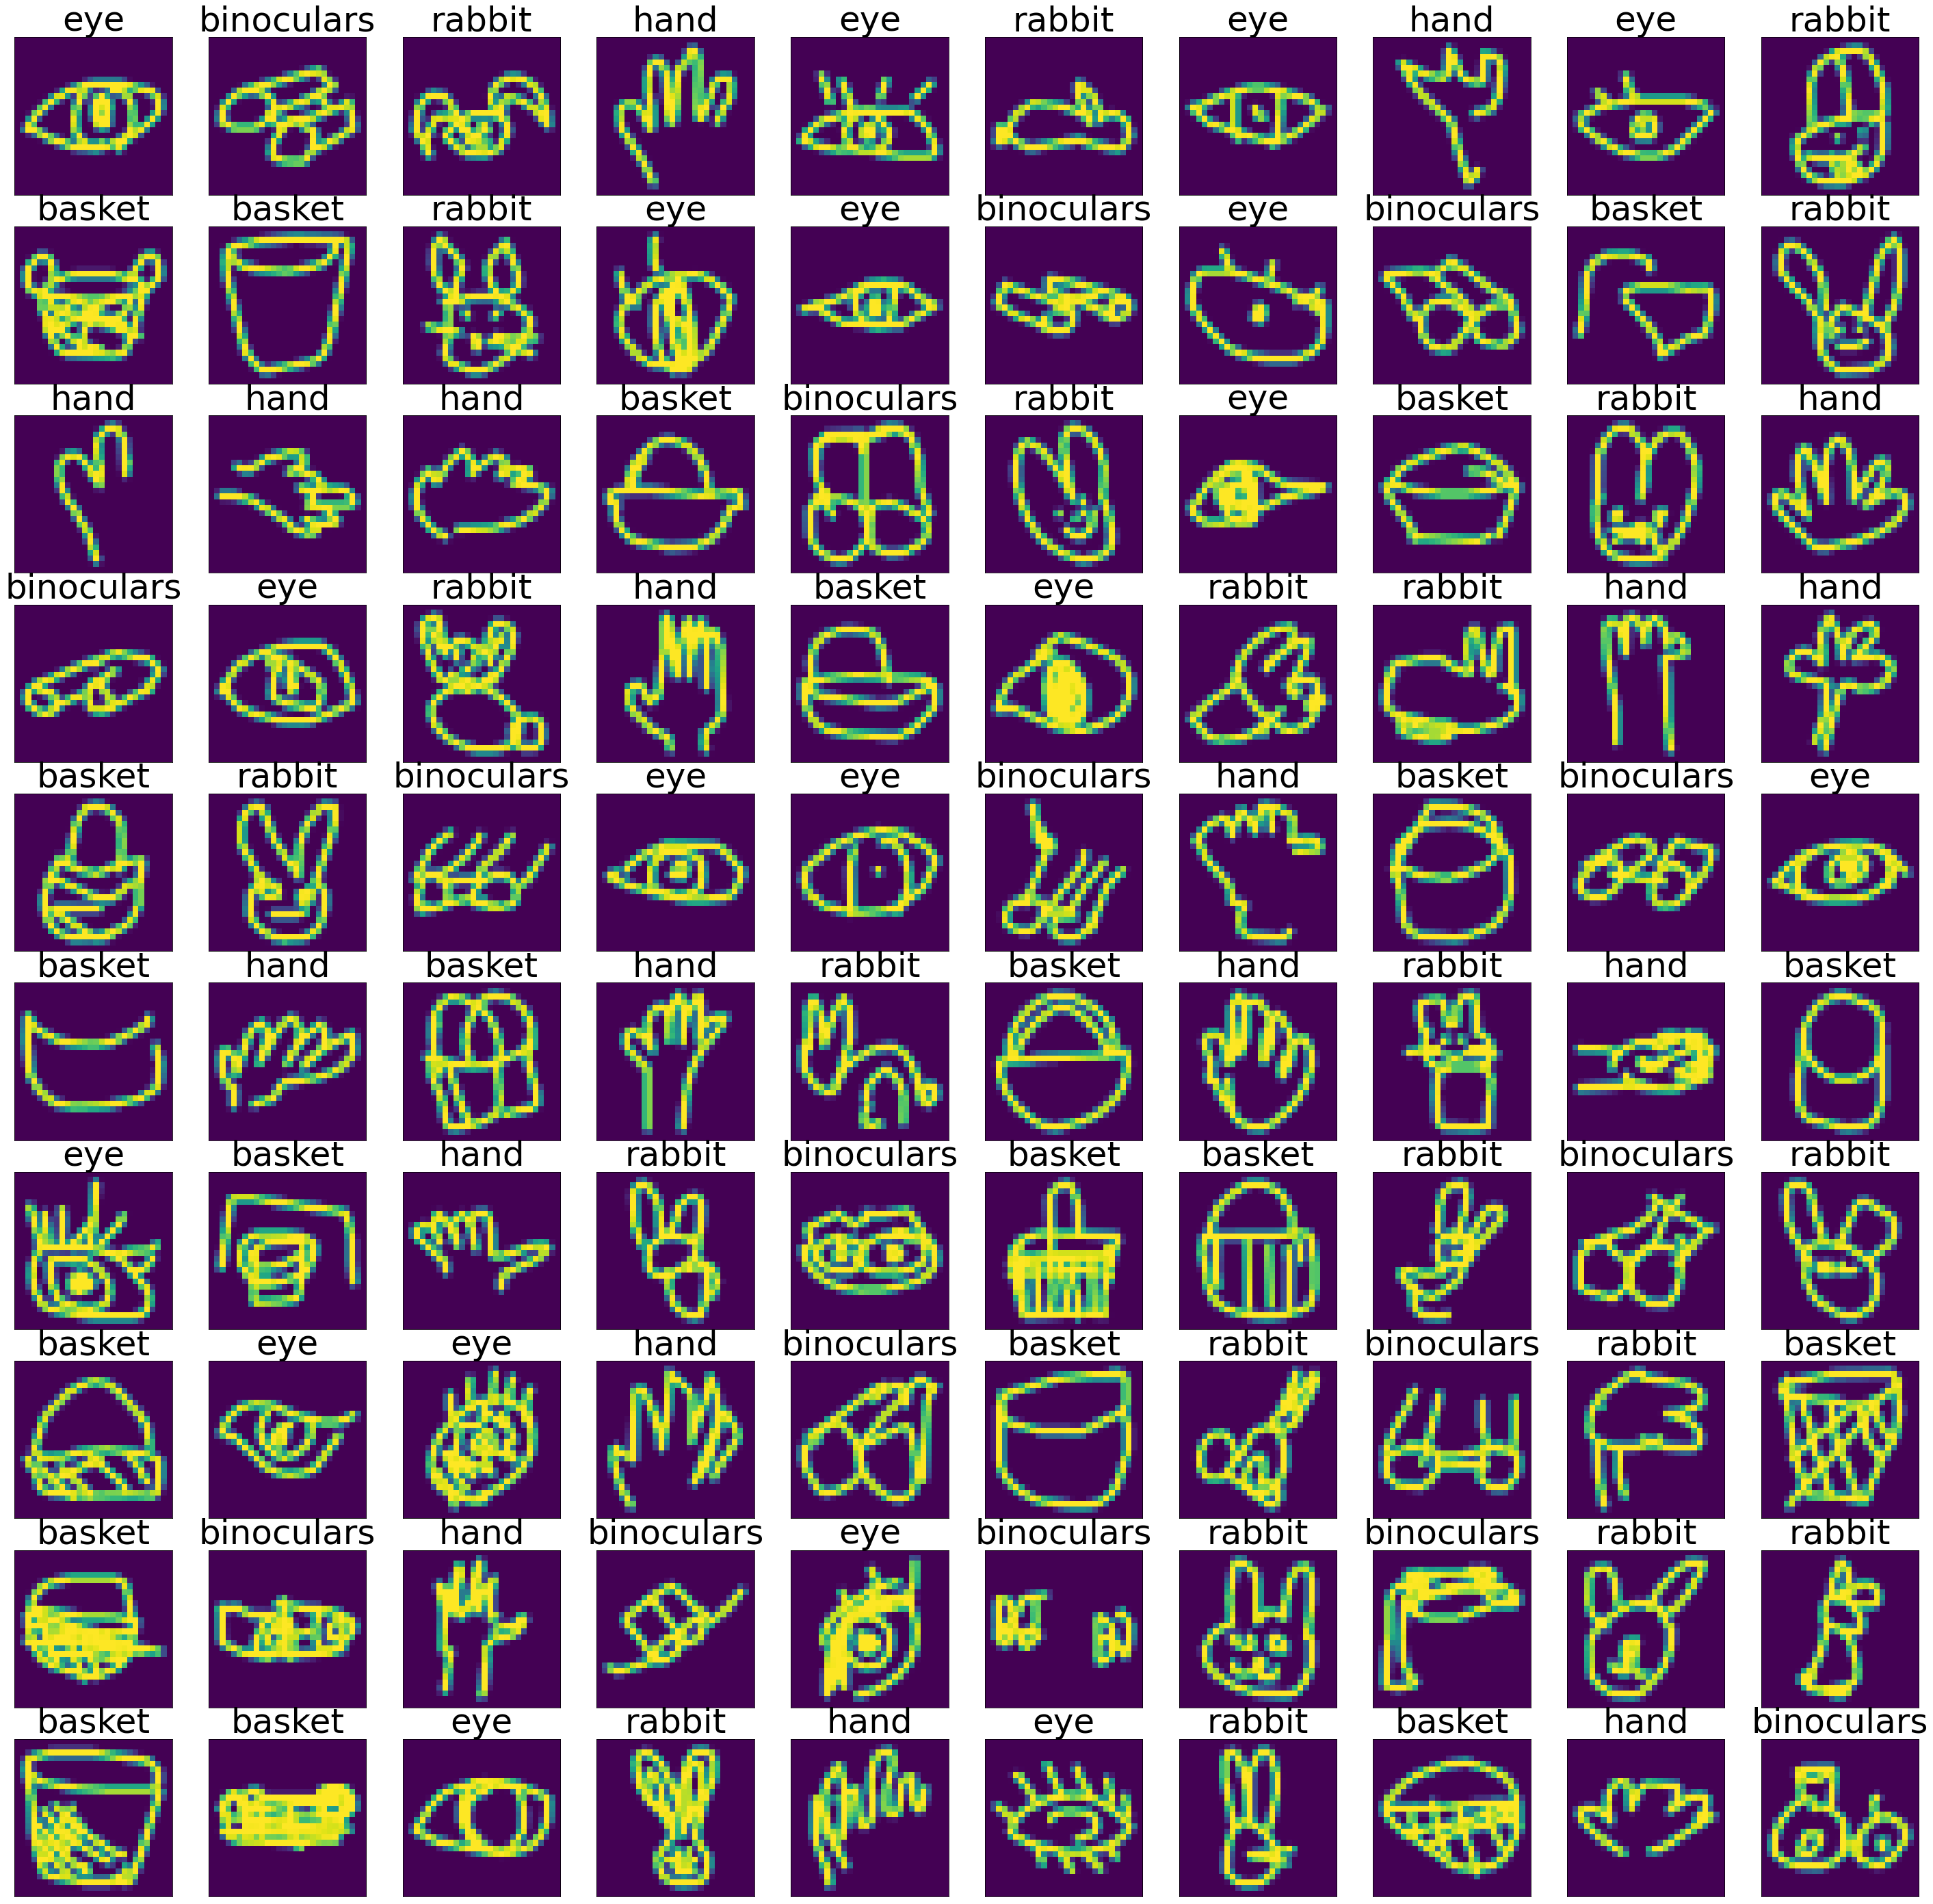

In [6]:
plt.figure(figsize=(50,50))
for i in range(100):
    ax= plt.subplot(10,10 ,i + 1)
    im = np.squeeze(x_train[i], axis=2)
    plt.title(classesIndex[np.where(y_train[i] == 1)[0][0]], fontdict = {'fontsize' : 50})
    fig=ax.imshow(im)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()    

### Définition du réseau
Le modèle utilisé et les paramètres d'entrainement sont similaires à ceux utilisés pour le jeu de donnée de base.
Pour ce jeu de données, nous avons réalisé les entrainements avec une taille de batch assez grande afin de réduire le temps de calcul.

In [41]:
lr = 0.0005
num_epochs = 40
batch_size = 2048
dropout = 0.75

In [52]:
model = Sequential([
  Conv2D(32,  input_shape=(28, 28, 1), kernel_size=(3,3), activation="relu", name="Conv1"),
  Conv2D(32, kernel_size=(3,3), activation="relu", name="Conv1b"),
  MaxPooling2D(pool_size=(2,2), name="MaxPool1"),    
  Conv2D(64, kernel_size=(3,3), activation="relu", name="Conv2"),
  Conv2D(64, kernel_size=(3,3), activation="relu", name="Conv2b"),
  MaxPooling2D(pool_size=(2,2), name="MaxPool2"),
  Flatten(name="Flatten"),
  Dropout(dropout, name="Dropout1"),
  Dense(1024, activation='relu', name="Dense1"),
  Dense(50, activation='relu', name="Dense2"),
  Dense(5, activation="softmax", name="Classif")                  
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 Conv1b (Conv2D)             (None, 24, 24, 32)        9248      
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 12, 12, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 10, 10, 64)        18496     
                                                                 
 Conv2b (Conv2D)             (None, 8, 8, 64)          36928     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 4, 4, 64)          0         
                                                                 
 Flatten (Flatten)           (None, 1024)             

In [53]:
optimizer = Adam(learning_rate=lr)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

### Entrainement du réseau

In [ ]:
#Chargement d'un réseau entrainé précédemment
model.load_weights(filepath='/content/drive/MyDrive/DeepLearning/trained_models/dataset_complet_validation_separee_v3/model.001-0.9750.h5') 

In [54]:
saveCallback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/DeepLearning/trained_models/dataset_complet_validation_separee_v5/model.{epoch:03d}-{val_accuracy:.4f}.h5')

early_stopping = EarlyStopping(monitor='val_loss', mode="min", patience=10)

hist = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[saveCallback, early_stopping], verbose=1)

Epoch 1/40
301/301 [==============================] - 48s 157ms/step - loss: 0.8251 - accuracy: 0.7499 - val_loss: 0.3080 - val_accuracy: 0.9024
Epoch 2/40
301/301 [==============================] - 47s 156ms/step - loss: 0.3081 - accuracy: 0.8966 - val_loss: 0.2310 - val_accuracy: 0.9238
Epoch 3/40
301/301 [==============================] - 47s 155ms/step - loss: 0.2423 - accuracy: 0.9189 - val_loss: 0.1785 - val_accuracy: 0.9395
Epoch 4/40
301/301 [==============================] - 47s 156ms/step - loss: 0.2089 - accuracy: 0.9297 - val_loss: 0.1627 - val_accuracy: 0.9453
Epoch 5/40
301/301 [==============================] - 47s 156ms/step - loss: 0.1875 - accuracy: 0.9368 - val_loss: 0.1459 - val_accuracy: 0.9509
Epoch 6/40
301/301 [==============================] - 47s 156ms/step - loss: 0.1724 - accuracy: 0.9419 - val_loss: 0.1407 - val_accuracy: 0.9530
Epoch 7/40
301/301 [==============================] - 47s 156ms/step - loss: 0.1604 - accuracy: 0.9460 - val_loss: 0.1335 - val_ac

### Courbes d'entrainement

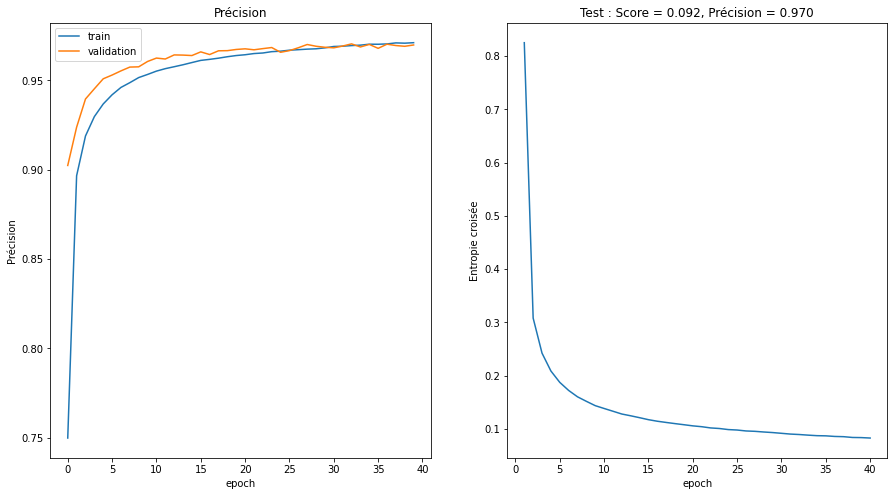

<Figure size 432x288 with 0 Axes>

In [55]:
score = model.evaluate(x_test, y_test, verbose=0)
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Précision')
plt.ylabel('Précision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

plt.subplot(1,2,2)
x = list(range(1,num_epochs+1))
l = hist.history['loss']
plt.xlabel('epoch')
plt.ylabel('Entropie croisée')
plt.title("Test : Score = {0:5.3f}, Précision = {1:5.3f}".format(score[0], score[1]))
plt.plot(x,l)
plt.show()
plt.tight_layout()

### Évaluation du modèle

Nombre d'erreurs 6044/200000




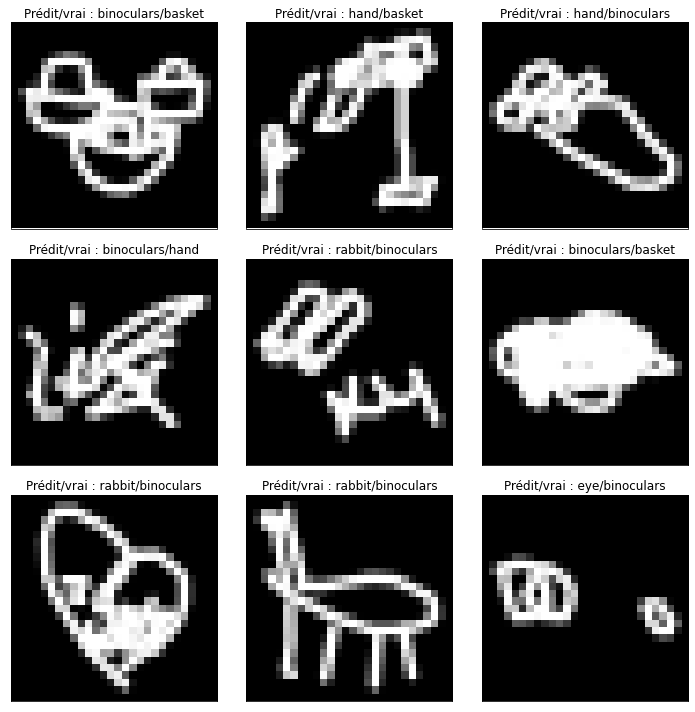

In [56]:
predicted_classes = np.argmax(model.predict(x_test), axis=-1)
y = np.argmax(y_test,axis=1)

incorrects = np.nonzero(predicted_classes != y)[0]
plt.figure(figsize=(10,10))
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrects[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title( "Prédit/vrai : {}/{}".format(classesIndex[predicted_classes[incorrects[i]]], classesIndex[y[incorrects[i]]]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
print("Nombre d'erreurs {}/{}\n\n".format(incorrects.size,y.size))

## Pour s'amuser :
Nous avons récupérer en ligne un morceau de code permettant de dessiner sur un canvas, et l'avons adapté afin de soumettre un dessin fait en direct à notre réseau.
Source du bloc de code ci - dessous : https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca

In [57]:
from IPython.display import HTML
from google.colab.output import eval_js
from base64 import b64decode
from keras.preprocessing import image

canvas_html = """
<canvas style="border: 1px solid black;"width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.jpg', w=200, h=200, line_width=5):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

In [58]:
import cv2
# Lecture de l'image sauvegardée
def lectureDessin(chemin="drawing.jpg"):
  an_image = Image.open(chemin)
  image_sequence = an_image.getdata()
  image_array = np.array(image_sequence)

  imageGrey = []
  for line in image_array:
    imageGrey.append(line[-1])

  imageGrey = np.array(imageGrey)
  imageGrey = imageGrey.reshape(200, 200, 1).astype('float32')

  dim=(28,28)
  imageGrey = cv2.resize(imageGrey, dim, interpolation = cv2.INTER_AREA)
  imageGrey = imageGrey.reshape(28, 28, 1).astype('uint8')

  return imageGrey

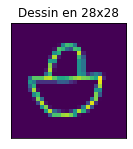

It's a basket !


In [68]:
draw()
img = lectureDessin()

plt.figure(figsize=(25,25))
ax= plt.subplot(10,10,1)
im = np.squeeze(img, axis=2)
fig=ax.imshow(im)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.title("Dessin en 28x28")
plt.show()    

predicted_classes = np.argmax(model.predict(np.array([img])), axis=-1)
print(f"It's a {classesIndex[predicted_classes[0]]} !")